2022-03-10

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Basic tests

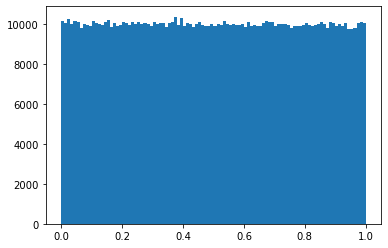

CPU times: user 256 ms, sys: 236 µs, total: 256 ms
Wall time: 253 ms


In [4]:
%%time
plt.hist(np.random.uniform(size=1000000), bins=100, range=[0,1])
plt.show()

# Generating RNs from arbitrary distributions
Assume distribution $p(x)$ defined on an interval $[a,b]$ .

## Trivial method of acceptance-rejection
1. Normalize $p(x)$ so it is always $\le 1$ (must have $\sup p(x) < \infty$)
2. Generate $N$ uniform values $x_i$ in $[a,b]$
3. Evaluate $f(x_i)$
5. Generate $N$ uniform values $r_i$ in $[0,1]$
6. Return the $x_i$ for which $r_i<p(x_i)$, repeat until we get enough samples

This can be very inefficient!

## Transformation method for continuous distributions
$$p_y(y)=\frac{p_x(x(y))}{\left|{\frac{\partial y}{\partial x}}\right|_{x=x(y)}}$$
If the derivative (or Jacobian if multidimensional) is monotonic, and we choose a uniform distribution $p_x(x)=1, x\in[0,1]$, we get
$$x(y)=\int_{y_{min}}^y p_y(y')\text d y'$$
And then we can invert the function $x(y)$ (also numerically, using a look-up table and interpolation) and use $y(x)$ to generate RNs distributed like $p_y$ using a uniform RNG.

## Transformation method for discrete distributions
1. Take the cumulant $F(n)=\sum_{i=n_{min}}^n P(i)$
2. Generate $N$ numbers $r_i$ in $U[0,1]$
3. Find the smallest $n$ such that $r_i<F(n)$, and return $n$

It's the same procedure as before, but the "discrete integral" (sum) makes it all easiert.

## Convolution method for continuous distributions
Some distributions are easy to write as $p(x_1+x_2)=p_1(x_1)\otimes p_2(x_2)$.
Example with a gaussian from uniform variables:
1. Generate 12 uniform random numbers in $[0,1]$ (they have $\sigma=1/\sqrt 12$)
2. Return the sum of the 12 numbers (the sum has $\sigma=1$) minus 6 (so the mean is zero

It's not too bad, and it's very fast.

norm        2.382e+04 +- 29.55     
mu          -0.000351 +- 0.001021  
sigma           1.006 +- 0.000758  
chi2/NDF        269.5 /  97        


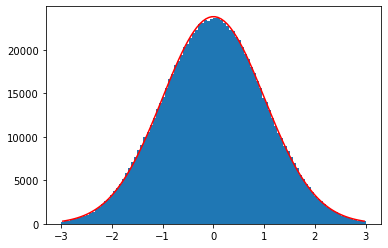

CPU times: user 330 ms, sys: 12 ms, total: 342 ms
Wall time: 340 ms


In [26]:
%%time
u_samples = [np.random.uniform(size=1000000) for _ in range(12)]
g_samples = sum(u_samples, np.zeros_like(u_samples[0])) - 6
y, x, _ = plt.hist(g_samples, bins=100, range=[-3, 3])
x = (x[1:] + x[:-1]) / 2
sigma = np.sqrt(y)
def g(x, norm, mu, sigma):
    return norm * np.exp(-(x-mu)**2 / (2*sigma**2))
popt, pcov = curve_fit(g, x, y, p0=[24e3, 0, 1], sigma=sigma, absolute_sigma=True)
pstd = np.sqrt(pcov.diagonal())
for name, value, std in zip(["norm", "mu", "sigma"], popt, pstd):
    print(f"{name:10s} {value:10.4g} +- {std:<10.4g}")
chi2 = np.sum(((y - g(x, *popt)) / sigma)**2)
ndf = len(y) - len(popt)
print(f"chi2/NDF   {chi2:10.4g} /  {ndf:<10d}")
plt.plot(x, g(x, *popt), 'r-')
plt.show()

## Markov-chain Monte Carlo (MCMC)
Particularly useful in many dimension and with complex functions (addresses the shortcomings of the previous inefficient methods: dimensionality curse and function complexity).
It does **not** need the $p(x)$ to be normalized (which can be very hard or impossible); this is particularly useful for Bayesian calculations, where the posterior usually has unknown/hard-to-compute normalization.

### Metropolis-Hastings algorithm
1. Pick a point $x_0$ (**any** point, can be non-random) in the distribution, can be multidimensional
2. Generate ("jump" to) the next point $x'$ from a pre-selected PDF $q(x';x)$ (**any** PDF, as long as it is symmetric $q(x;x')=q(x';x)$)
3. If $r<p(x')/p(x)$ return $x'$, otherwise keep going (this is similar to the accept-reject method)
4. Iterate

Drawback: nearby samples will be correlated (must make sure it does not matter).

## Calculating integrals with MC
Generate random numbers $x_i$ and compute $f(x_i)$, then use
$$\frac{1}{N}\sum_{i=1}^N f(x_i)\to \langle f\rangle = \frac{1}{V}\int_V f(x)\text d x$$
This is _very_ effective for multidimensional integrals, much more than deterministic rules (even Simpson's rule performs badly in multidimensional cases).
$$\sigma_I=V\frac{\sigma_f}{\sqrt N}$$
While Simspon's rule (deterministic!) performs
$$\sigma_I\propto N^{-4/D}$$
where $D$ is the number of dimensions (yes, using a MC gets a $\sigma$ that is _indepdendent_ on the number of dimensions!).

# Exercises
Display a few distributions (try each method for at least one distribution):

 - exponential,
 - triangular,
 - gaussian,
 - Poisson,
 - binomial,
 - Cauchy, and
 - $p(x,y)\propto xy^2+x$ in $[0,1]\times[0,1]$.

Determine the volume of a sphere in 13 dimensions (there is also the analytical formula to check the results).